# deterministic and EKF using paper's jacobian 

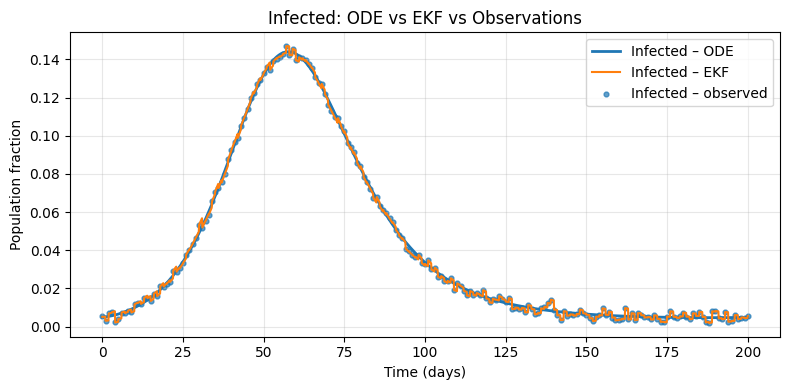

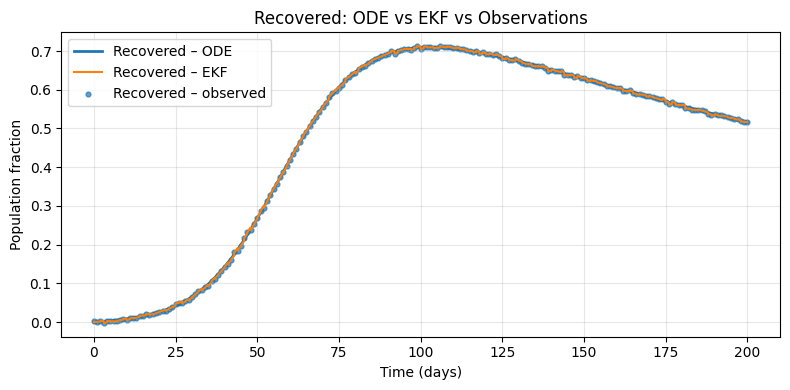

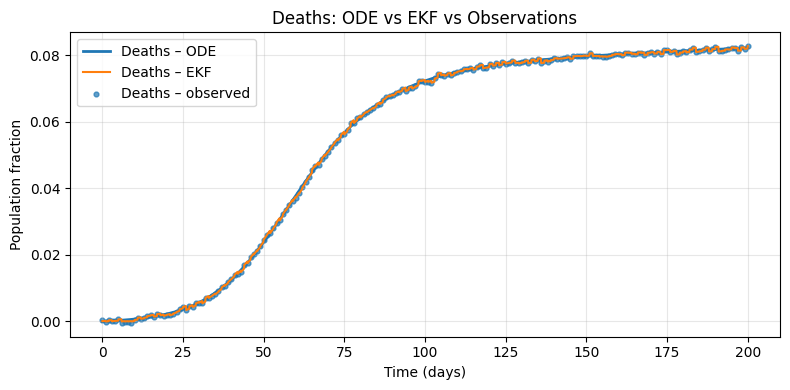

RMSE Infected:  0.001721
RMSE Recovered: 0.002016
RMSE Deaths:    0.000399


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

# --- Parameters ---
alpha = 0.14  # exposed → infected rate
beta = 0.6    # base transmission coefficient
gamma = 0.12  # recovery rate
mu    = 0.01  # death rate
kappa = 0.005 # reinfection rate (R -> S)
rho   = 0.6   # social distancing factor
N     = 1.0   # normalized population

# --- Time and State Initialization ---
T_days = 200
dt = 0.1
t = np.arange(0, T_days + dt, dt)
S0, E0, I0, R0, D0 = 0.99, 0.005, 0.005, 0.0, 0.0
S, E, I, R, D = (np.empty_like(t) for _ in range(5))
S[0], E[0], I[0], R[0], D[0] = S0, E0, I0, R0, D0

# --- ODE Integration (Euler) ---
for k in range(1, t.size):
    s, e, i, r, d = S[k-1], E[k-1], I[k-1], R[k-1], D[k-1]
    dS = -rho * beta * s * i / N + kappa * r
    dE =  rho * beta * s * i / N - alpha * e
    dI =  alpha * e - (gamma + mu) * i
    dR =  gamma * i - kappa * r
    dD =  mu * i
    S[k] = s + dS * dt
    E[k] = e + dE * dt
    I[k] = i + dI * dt
    R[k] = r + dR * dt
    D[k] = d + dD * dt

# --- Simulated Observations (daily + noise) ---
rng = np.random.default_rng(42)
obs_mask = np.isclose(t % 1.0, 0.0, atol=1e-12)
obs_times = t[obs_mask]
sigma_I, sigma_R, sigma_D = 0.002, 0.002, 0.0004
true_I_obs = I[obs_mask] + rng.normal(0, sigma_I, size=obs_times.size)
true_R_obs = R[obs_mask] + rng.normal(0, sigma_R, size=obs_times.size)
true_D_obs = D[obs_mask] + rng.normal(0, sigma_D, size=obs_times.size)

# --- EKF Model Setup ---
Q = 0.001 * np.eye(4)  # Process noise (S, E, I, D)
R_cov = np.diag([sigma_I**2, sigma_R**2, sigma_D**2])  # Measurement noise

def f_continuous(x):
    s, e, i, d = x
    r = N - (s + e + i + d)
    dS = -rho * beta * s * i / N + kappa * r
    dE =  rho * beta * s * i / N - alpha * e
    dI =  alpha * e - (gamma + mu) * i
    dD =  mu * i
    return np.array([dS, dE, dI, dD])

def compute_jacobian_F(x):
    s, e, i, d = x
    r = N - (s + e + i + d)
    I_N = i / N
    S_N = s / N
    F = np.zeros((4,4))
    # Jacobian (per Eq 21)
    F[0,0] = 1 - rho * beta * I_N  # dS/dS
    F[0,1] = 0
    F[0,2] = -rho * beta * S_N - kappa * r  # dS/dI
    F[0,3] = 0         # dS/dD
    F[1,0] = -rho * beta * I_N
    F[1,1] = 1 - alpha
    F[1,2] = rho * beta * S_N
    F[1,3] = 0
    F[2,0] = 0
    F[2,1] = alpha
    F[2,2] = 1 - (gamma + mu)
    F[2,3] = 0
    F[3,0] = 0
    F[3,1] = 0
    F[3,2] = mu
    F[3,3] = 1
    return F

def h(x):
    s, e, i, d = x
    r = N - (s + e + i + d)
    return np.array([i, r, d])

def jacobian_h(x):
    # dh/dx, 3x4, matches measurement vector
    return np.array([
        [0.0, 0.0, 1.0, 0.0],           # dI
        [-1.0, -1.0, -1.0, -1.0],       # dR
        [0.0, 0.0, 0.0, 1.0],           # dD
    ])

# --- EKF Loop ---
x_est = np.zeros((4, t.size))
P = np.eye(4) * 1e-4
x_est[:,0] = np.array([S0, E0, I0, D0]) + rng.normal(0, 1e-4, size=4)
P_est = np.zeros((4, 4, t.size))
P_est[:,:,0] = P
obs_idx = np.where(obs_mask)[0]

for k in range(1, t.size):
    x_prev = x_est[:,k-1].copy()
    P_prev = P.copy()
    # Predict
    f_x = f_continuous(x_prev)
    x_pred = x_prev + f_x * dt
    F = compute_jacobian_F(x_prev)
    P_pred = F @ P_prev @ F.T + Q
    # Update (if observation)
    if k in obs_idx:
        obs_pos = np.where(obs_idx == k)[0][0]
        z = np.array([true_I_obs[obs_pos], true_R_obs[obs_pos], true_D_obs[obs_pos]])
        z_pred = h(x_pred)
        H = jacobian_h(x_pred)
        S_mat = H @ P_pred @ H.T + R_cov
        K = P_pred @ H.T @ np.linalg.inv(S_mat)
        y = z - z_pred
        x_upd = x_pred + K @ y
        x_upd = np.maximum(x_upd, 0.0)
        I4 = np.eye(4)
        P = (I4 - K @ H) @ P_pred @ (I4 - K @ H).T + K @ R_cov @ K.T  # Joseph form for symmetry
        x_est[:,k] = x_upd
    else:
        x_est[:,k] = x_pred
        P = P_pred
    P_est[:,:,k] = P

# Reconstruct R from conservation: R = N - (S+E+I+D)
S_est, E_est, I_est, D_est = x_est
R_est = N - (S_est + E_est + I_est + D_est)

# --- Plotting ---
plt.figure(figsize=(8, 4))
plt.plot(t, I, lw=2, label="Infected – ODE")
plt.plot(t, I_est, lw=1.5, label="Infected – EKF")
plt.scatter(obs_times, true_I_obs, s=12, label="Infected – observed", alpha=0.7)
plt.xlabel("Time (days)")
plt.ylabel("Population fraction")
plt.title("Infected: ODE vs EKF vs Observations")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(t, R, lw=2, label="Recovered – ODE")
plt.plot(t, R_est, lw=1.5, label="Recovered – EKF")
plt.scatter(obs_times, true_R_obs, s=12, label="Recovered – observed", alpha=0.7)
plt.xlabel("Time (days)")
plt.ylabel("Population fraction")
plt.title("Recovered: ODE vs EKF vs Observations")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(t, D, lw=2, label="Deaths – ODE")
plt.plot(t, D_est, lw=1.5, label="Deaths – EKF")
plt.scatter(obs_times, true_D_obs, s=12, label="Deaths – observed", alpha=0.7)
plt.xlabel("Time (days)")
plt.ylabel("Population fraction")
plt.title("Deaths: ODE vs EKF vs Observations")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

rmse_I = root_mean_squared_error(I, I_est)
rmse_R = root_mean_squared_error(R, R_est)
rmse_D = root_mean_squared_error(D, D_est)
print(f"RMSE Infected:  {rmse_I:.6f}")
print(f"RMSE Recovered: {rmse_R:.6f}")
print(f"RMSE Deaths:    {rmse_D:.6f}")


# deterministic and EKF, using my jacobian

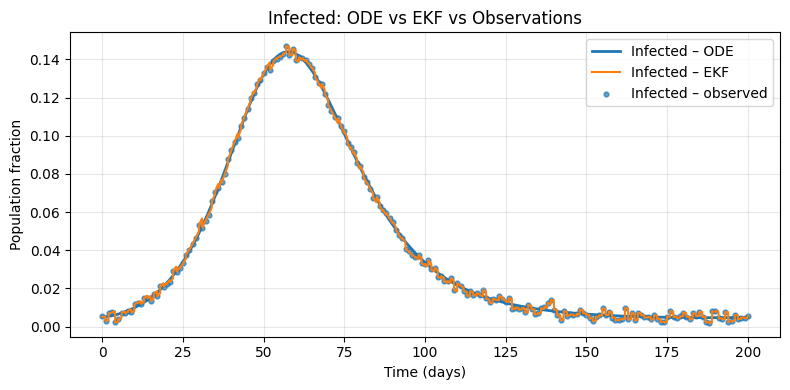

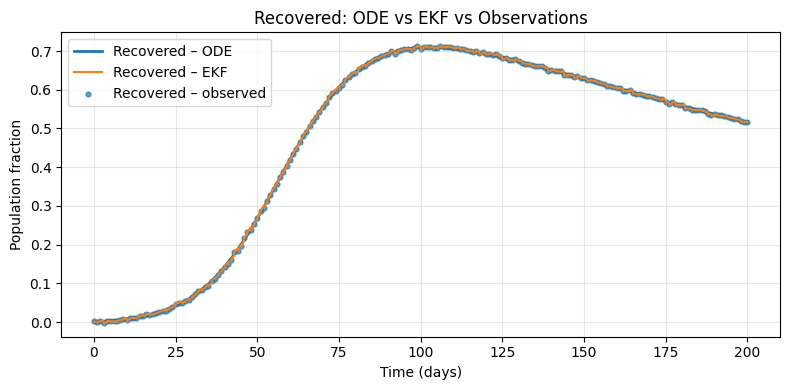

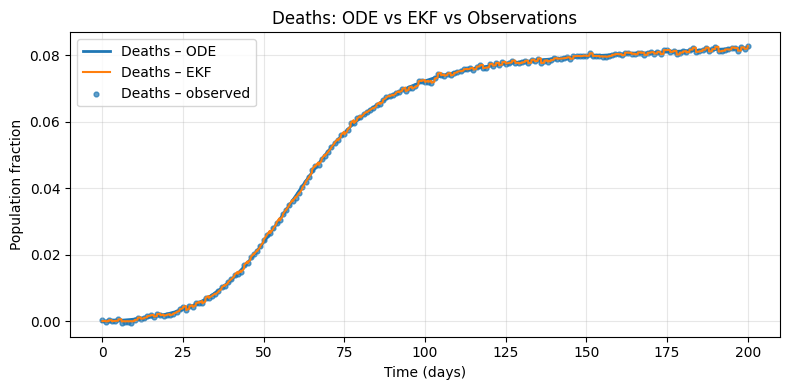

RMSE Infected:  0.001713
RMSE Recovered: 0.002016
RMSE Deaths:    0.000399


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

# --- Parameters ---
alpha = 0.14  # exposed → infected rate
beta = 0.6    # base transmission coefficient
gamma = 0.12  # recovery rate
mu    = 0.01  # death rate
kappa = 0.005 # reinfection rate (R -> S)
rho   = 0.6   # social distancing factor
N     = 1.0   # normalized population

# --- Time and State Initialization ---
T_days = 200
dt = 0.1
t = np.arange(0, T_days + dt, dt)
S0, E0, I0, R0, D0 = 0.99, 0.005, 0.005, 0.0, 0.0
S, E, I, R, D = (np.empty_like(t) for _ in range(5))
S[0], E[0], I[0], R[0], D[0] = S0, E0, I0, R0, D0

# --- ODE Integration (Euler) ---
for k in range(1, t.size):
    s, e, i, r, d = S[k-1], E[k-1], I[k-1], R[k-1], D[k-1]
    dS = -rho * beta * s * i / N + kappa * r
    dE =  rho * beta * s * i / N - alpha * e
    dI =  alpha * e - (gamma + mu) * i
    dR =  gamma * i - kappa * r
    dD =  mu * i
    S[k] = s + dS * dt
    E[k] = e + dE * dt
    I[k] = i + dI * dt
    R[k] = r + dR * dt
    D[k] = d + dD * dt

# --- Simulated Observations (daily + noise) ---
rng = np.random.default_rng(42)
obs_mask = np.isclose(t % 1.0, 0.0, atol=1e-12)
obs_times = t[obs_mask]
sigma_I, sigma_R, sigma_D = 0.002, 0.002, 0.0004
true_I_obs = I[obs_mask] + rng.normal(0, sigma_I, size=obs_times.size)
true_R_obs = R[obs_mask] + rng.normal(0, sigma_R, size=obs_times.size)
true_D_obs = D[obs_mask] + rng.normal(0, sigma_D, size=obs_times.size)

# --- EKF Model Setup ---
Q = 0.001 * np.eye(4)  # Process noise (S, E, I, D)
R_cov = np.diag([sigma_I**2, sigma_R**2, sigma_D**2])  # Measurement noise

def f_continuous(x):
    s, e, i, d = x
    r = N - (s + e + i + d)
    dS = -rho * beta * s * i / N + kappa * r
    dE =  rho * beta * s * i / N - alpha * e
    dI =  alpha * e - (gamma + mu) * i
    dD =  mu * i
    return np.array([dS, dE, dI, dD])

def compute_jacobian_F(x):
    s, e, i, d = x
    r = N - (s + e + i + d)
    I_N = i / N
    S_N = s / N
    F = np.zeros((4,4))
    # Jacobian (per Eq 21)
    F[0,0] = -rho * beta * I_N - kappa + 1  # dS/dS
    F[0,1] = -kappa
    F[0,2] = -rho * beta * S_N - kappa  # dS/dI
    F[0,3] = -kappa        # dS/dD
    F[1,0] = rho * beta * I_N
    F[1,1] = 1 - alpha
    F[1,2] = rho * beta * S_N
    F[1,3] = 0
    F[2,0] = 0
    F[2,1] = alpha
    F[2,2] = 1 - (gamma + mu)
    F[2,3] = 0
    F[3,0] = 0
    F[3,1] = 0
    F[3,2] = mu
    F[3,3] = 1
    return F

def h(x):
    s, e, i, d = x
    r = N - (s + e + i + d)
    return np.array([i, r, d])

def jacobian_h(x):
    # dh/dx, 3x4, matches measurement vector
    return np.array([
        [0.0, 0.0, 1.0, 0.0],           # dI
        [-1.0, -1.0, -1.0, -1.0],       # dR
        [0.0, 0.0, 0.0, 1.0],           # dD
    ])

# --- EKF Loop ---
x_est = np.zeros((4, t.size))
P = np.eye(4) * 1e-4
x_est[:,0] = np.array([S0, E0, I0, D0]) + rng.normal(0, 1e-4, size=4)
P_est = np.zeros((4, 4, t.size))
P_est[:,:,0] = P
obs_idx = np.where(obs_mask)[0]

for k in range(1, t.size):
    x_prev = x_est[:,k-1].copy()
    P_prev = P.copy()
    # Predict
    f_x = f_continuous(x_prev)
    x_pred = x_prev + f_x * dt
    F = compute_jacobian_F(x_prev)
    P_pred = F @ P_prev @ F.T + Q
    # Update (if observation)
    if k in obs_idx:
        obs_pos = np.where(obs_idx == k)[0][0]
        z = np.array([true_I_obs[obs_pos], true_R_obs[obs_pos], true_D_obs[obs_pos]])
        z_pred = h(x_pred)
        H = jacobian_h(x_pred)
        S_mat = H @ P_pred @ H.T + R_cov
        K = P_pred @ H.T @ np.linalg.inv(S_mat)
        y = z - z_pred
        x_upd = x_pred + K @ y
        x_upd = np.maximum(x_upd, 0.0)
        I4 = np.eye(4)
        P = (I4 - K @ H) @ P_pred @ (I4 - K @ H).T + K @ R_cov @ K.T  # Joseph form for symmetry
        x_est[:,k] = x_upd
    else:
        x_est[:,k] = x_pred
        P = P_pred
    P_est[:,:,k] = P

# Reconstruct R from conservation: R = N - (S+E+I+D)
S_est, E_est, I_est, D_est = x_est
R_est = N - (S_est + E_est + I_est + D_est)

# --- Plotting ---
plt.figure(figsize=(8, 4))
plt.plot(t, I, lw=2, label="Infected – ODE")
plt.plot(t, I_est, lw=1.5, label="Infected – EKF")
plt.scatter(obs_times, true_I_obs, s=12, label="Infected – observed", alpha=0.7)
plt.xlabel("Time (days)")
plt.ylabel("Population fraction")
plt.title("Infected: ODE vs EKF vs Observations")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(t, R, lw=2, label="Recovered – ODE")
plt.plot(t, R_est, lw=1.5, label="Recovered – EKF")
plt.scatter(obs_times, true_R_obs, s=12, label="Recovered – observed", alpha=0.7)
plt.xlabel("Time (days)")
plt.ylabel("Population fraction")
plt.title("Recovered: ODE vs EKF vs Observations")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(t, D, lw=2, label="Deaths – ODE")
plt.plot(t, D_est, lw=1.5, label="Deaths – EKF")
plt.scatter(obs_times, true_D_obs, s=12, label="Deaths – observed", alpha=0.7)
plt.xlabel("Time (days)")
plt.ylabel("Population fraction")
plt.title("Deaths: ODE vs EKF vs Observations")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

rmse_I = root_mean_squared_error(I, I_est)
rmse_R = root_mean_squared_error(R, R_est)
rmse_D = root_mean_squared_error(D, D_est)
print(f"RMSE Infected:  {rmse_I:.6f}")
print(f"RMSE Recovered: {rmse_R:.6f}")
print(f"RMSE Deaths:    {rmse_D:.6f}")
